In [2]:
import argparse
import numpy as np
from tqdm import tqdm
import sys


from modeling.build_model import Pose2Seg
from datasets2.CocoDatasetInfo import CocoDatasetInfo, annToMask
from pycocotools import mask as maskUtils
from torchmetrics import JaccardIndex
from torchmetrics.classification import BinaryJaccardIndex
import torch

In [3]:
model_checkpoint = "nvidia/mit-b0"  # pre-trained model from which to fine-tune
ImageRoot = './data/OCHuman/images'
AnnoFile = './data/OCHuman/annotations/ochuman_coco_format_test_range_0.00_1.00.json'

In [4]:
datainfos = CocoDatasetInfo(ImageRoot, AnnoFile, onlyperson=True, loadimg=True)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [6]:
# import evaluate
# metric = evaluate.load("mean_iou")
from transformers import AutoImageProcessor
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
2023-04-17 14:07:58.569516: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-17 14:07:58.703470: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 14:07:59.358851: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/kevinw/miniconda3/envs/pbd/lib/python3.11/site-packages/transformers/models/segform

SegformerImageProcessor {
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SegformerImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  }
}

In [9]:
# from transformers import SegformerModel
# model = SegformerModel(model_checkpoint)

ValueError: Parameter config in `SegformerModel(config)` should be an instance of class `PretrainedConfig`. To create a model from a pretrained model use `model = SegformerModel.from_pretrained(PRETRAINED_MODEL_NAME)`

In [29]:
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import requests
device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint = "nvidia/mit-b0"
image_processor = AutoImageProcessor.from_pretrained(checkpoint, reduce_labels=True)
model = SegformerForSemanticSegmentation.from_pretrained(checkpoint).to(device)

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = image_processor(images=image, return_tensors="pt").to(device)
outputs = model(**inputs)
logits = outputs.logits.cpu()  # shape (batch_size, num_labels, height/4, width/4)
list(logits.shape)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/home/kevinw/miniconda3/envs/pbd/lib/python3.11/site-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(
Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be e

[1, 1000, 128, 128]

In [30]:
import torch.nn as nn
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

In [55]:
pred_seg.shape

torch.Size([480, 640])

In [40]:
import matplotlib.pyplot as plt


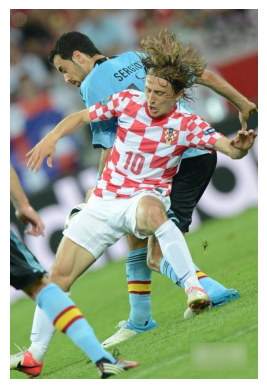

In [82]:
from PIL import Image
  
# open method used to open different extension image file
img = Image.open("test.png") 
  
# This method will show image in any image viewer 
img.show() 

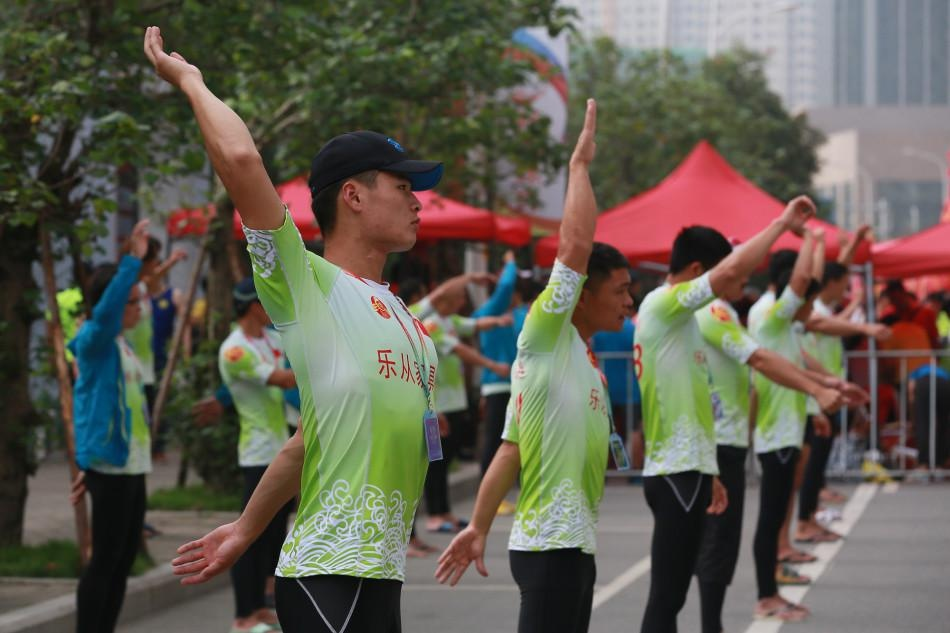

In [97]:
import cv2
rawdata = datainfos[1]
img = rawdata['data']
img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img2 = Image.fromarray(img2,'RGB')
img2.show()
# img2 = img

In [73]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]


In [99]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "nvidia/segformer-b5-finetuned-ade-640-640"
feature_extractor = SegformerFeatureExtractor.from_pretrained(model_name)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)
model.to(device)
print()


/home/kevinw/miniconda3/envs/pbd/lib/python3.11/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/home/kevinw/miniconda3/envs/pbd/lib/python3.11/site-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [134]:
rawdata = datainfos[3]
img = rawdata['data']
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img.shape
pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
output = model(pixel_values)
logits = output.logits.cpu()
upsampled_logits = nn.functional.interpolate(
    logits,
    size=img.shape[0:2],
    mode="bilinear",
    align_corners=False,
)
pred_seg = upsampled_logits.argmax(dim=1)[0]
pred_seg[pred_seg!=12]=0
color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[pred_seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

In [126]:
pred_seg

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

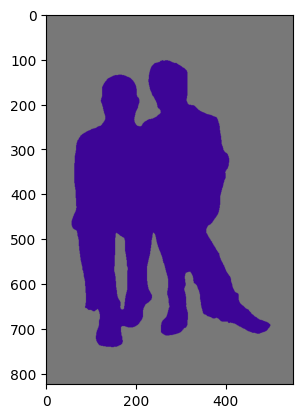

In [135]:
plt.imshow(color_seg.astype(np.uint8))

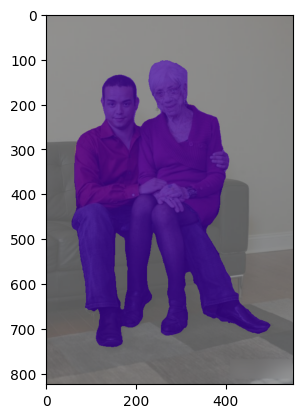

In [139]:
img = (np.array(img) * 0.5 + color_seg * 0.5).astype(np.uint8)

plt.imshow(img)

  0%|          | 0/2231 [00:00<?, ?it/s]

iou tensor(0.3785)


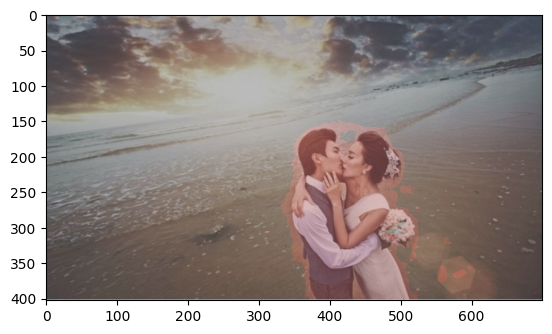

  9%|▉         | 200/2231 [00:32<05:22,  6.30it/s]

iou tensor(0.3372)


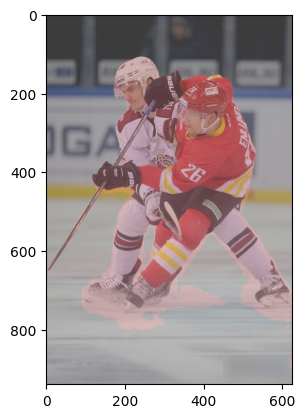

 18%|█▊        | 400/2231 [01:04<05:03,  6.03it/s]

iou tensor(0.7242)


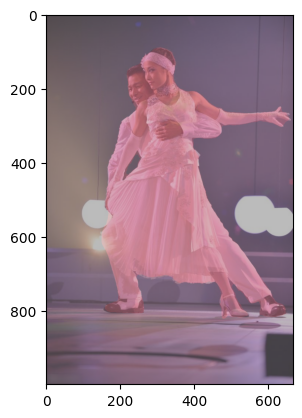

 27%|██▋       | 600/2231 [01:36<04:05,  6.64it/s]

iou tensor(0.2019)


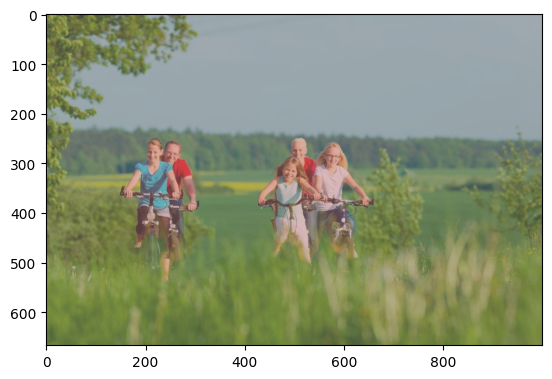

 36%|███▌      | 800/2231 [02:08<03:55,  6.08it/s]

iou tensor(0.2863)


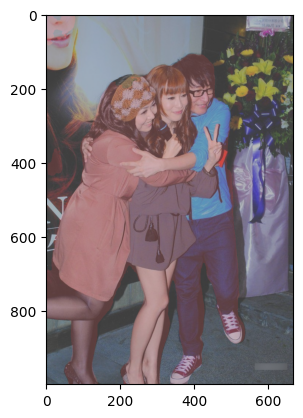

 45%|████▍     | 1000/2231 [02:41<03:14,  6.34it/s]

iou tensor(0.5909)


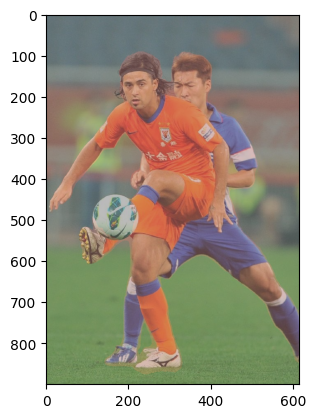

 54%|█████▍    | 1200/2231 [03:13<02:25,  7.11it/s]

iou tensor(0.4640)


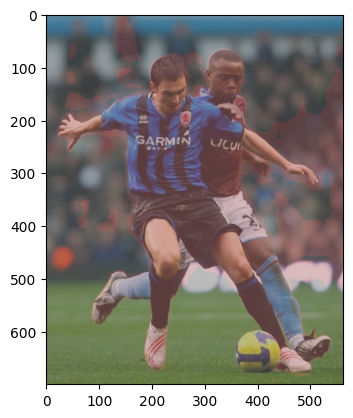

 63%|██████▎   | 1400/2231 [03:45<02:12,  6.25it/s]

iou tensor(0.5285)


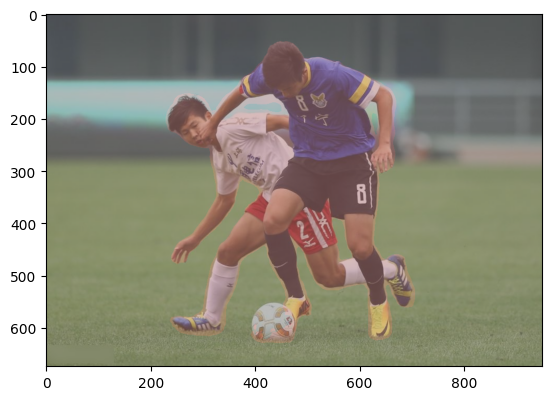

 72%|███████▏  | 1600/2231 [04:16<01:30,  7.00it/s]

iou tensor(0.5321)


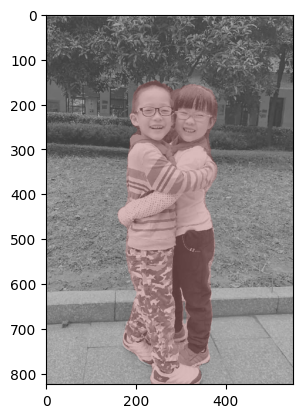

 81%|████████  | 1800/2231 [04:47<00:58,  7.34it/s]

iou tensor(0.6033)


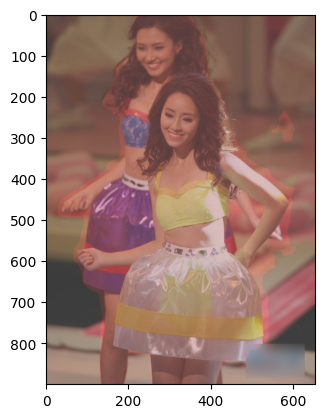

 90%|████████▉ | 2000/2231 [05:19<00:34,  6.62it/s]

iou tensor(0.5290)


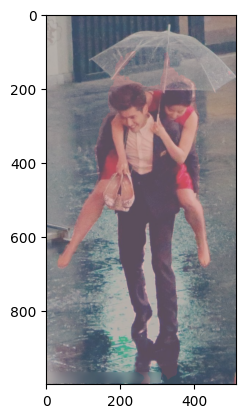

 99%|█████████▊| 2200/2231 [05:51<00:04,  6.36it/s]

iou tensor(0.5221)


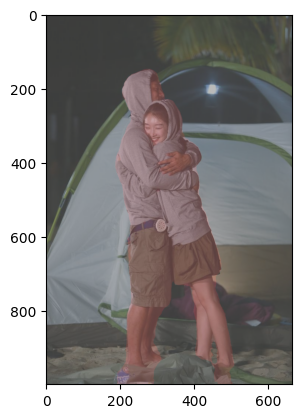

100%|██████████| 2231/2231 [05:56<00:00,  6.26it/s]


mean_iou tensor(0.3690)
Loading and preparing results...


IndexError: list index out of range

In [141]:
results_segm = []
imgIds = []
mean_iou = 0

for i in tqdm(range(len(datainfos))):
        rawdata = datainfos[i]
        img = rawdata['data']
        image_id = rawdata['id']
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # plt.imshow(img)
        pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
        output = model(pixel_values)
        logits = output.logits.cpu()

        height, width = img.shape[0:2]
        gt_segms = rawdata['segms']
        gt_masks = np.array([annToMask(segm, height, width) for segm in gt_segms])

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=img.shape[0:2],
            mode="bilinear",
            align_corners=False,
        )
        pred_seg = upsampled_logits.argmax(dim=1)[0]
        pred_seg[pred_seg!=12]=0
        pred_seg[pred_seg==12]=1
        # pred_seg = pred_seg.long()
        imgIds.append(image_id)

        metric = BinaryJaccardIndex()
        iou = metric(pred_seg,torch.from_numpy(gt_masks[0]))
        mean_iou = (iou-mean_iou)/(i+1) + mean_iou
        if i%200==0:
            print("iou",iou)
            color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8) # height, width, 3
            palette = np.array(ade_palette())
            for label, color in enumerate(palette):
                color_seg[pred_seg == label, :] = color
            img = (np.array(img) * 0.5 + color_seg * 0.5).astype(np.uint8)
            plt.imshow(img)
            plt.show()
print("mean_iou", mean_iou)
def do_eval_coco(image_ids, coco, results, flag):
    from pycocotools.cocoeval import COCOeval
    assert flag in ['bbox', 'segm', 'keypoints']
    # Evaluate
    coco_results = coco.loadRes(results)
    cocoEval = COCOeval(coco, coco_results, flag)
    cocoEval.params.imgIds = image_ids
    cocoEval.params.catIds = [1]
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize() 
    return cocoEval
    
cocoEval = do_eval_coco(imgIds, datainfos.COCO, results_segm, 'segm')
print('[POSE2SEG]          AP|.5|.75| S| M| L|    AR|.5|.75| S| M| L|')
_str = '[segm_score] OCHuman'
for value in cocoEval.stats.tolist():
    _str += '%.3f '%value
    plt.imshow(color_seg.astype(np.uint8))
print(_str)

In [38]:
pred_seg

tensor([[257, 257, 257,  ..., 464, 464, 464],
        [257, 257, 257,  ..., 464, 464, 464],
        [257, 257, 257,  ..., 464, 464, 464],
        ...,
        [748, 748, 748,  ..., 876, 876, 876],
        [899, 899, 899,  ..., 876, 876, 876],
        [899, 899, 899,  ..., 876, 876, 876]])

In [71]:
import torch
from torch import nn
import evaluate

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    # currently using _compute instead of compute
    # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=feature_extractor.do_reduce_labels,
        )
    
    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})
    
    return metrics

ImportError: cannot import name 'Dataset' from 'datasets' (/home/kevinw/Photo-Bomb-Diffuser/Other_Repos/Pose2Seg/datasets/__init__.py)

/home/kevinw/miniconda3/envs/pbd/lib/python3.11/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/home/kevinw/miniconda3/envs/pbd/lib/python3.11/site-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


NameError: name 'hf_username' is not defined